In [1]:
# Housing Price Prediction and Model Selection 

In [2]:
### Introduction:
# This project inspect the relationship between housing prices and multiple housing characteristics using a dataset of 545 
# observations. The objectives are to evaluate the performances of linear, regularized and non-linear regression models by comparing their test RMSE.
# The test RMSE is chosen to be the final benchmark instead of normal test MSE because RMSE is easier to interpret since it is in the same unit as 
# variable price. The three specific models to be compared are: Ordinary Least Squares (OLS), Ridge Regression and Cubic Spline Regression. One-fifth 
# of the whole dataset will be taken out as the test set and the rest as the training set. Cross-validation will be used as an official procdure to 
# determine the best hyperparameters (lambda, number of knots), which will ultimately be refitted into the whole training set to define the final model 
# structure.

In [3]:
### Data description: The dataset contains 545 observations of housing characteristics:
## Continuous variables:
# Area
# Nr of bedrooms
# Nr of bathrooms
# Nr of stories
# Parking spaces

## Binary variables:
# Main road access
# Hot water heating
# Basement
# Air conditioning
# Preffered area
# Guest room

## Categorical variable:
# Furnishing status (Furnished, semi-furnished, unfurnished)

# Binary regressors are represented by 1/0. One category of furnishing status variable will be left out as a reference group (furnished) while the
# other two are turned into two binary variales. 

In [4]:
### Assumptions:
## OLS assumptions:
# The underlying relationship between prices and estimators are closed to linear
# No absolute correlations between regressors
# Errors variances are the same 
# Observations are independent

## Ridge regression reduce the risk of multicollinearity between X's in OLS by introducing L2 regularization 

## Spline regression apply cubic spline on countinuous variables while keeping linear estimations for binary variables 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
housing_raw = pd.read_csv('HPfile.csv')
housing_raw = housing_raw.dropna()
housing_raw.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [7]:
## Preprocess the raw data:
binary_cols = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea']

housing = pd.get_dummies(housing_raw, columns = ['furnishingstatus'], drop_first = True)

for col in binary_cols:
    housing[col] = housing_raw[col].map({'yes': 1, 'no': 0})

housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [8]:
housing.shape

(545, 14)

In [9]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000


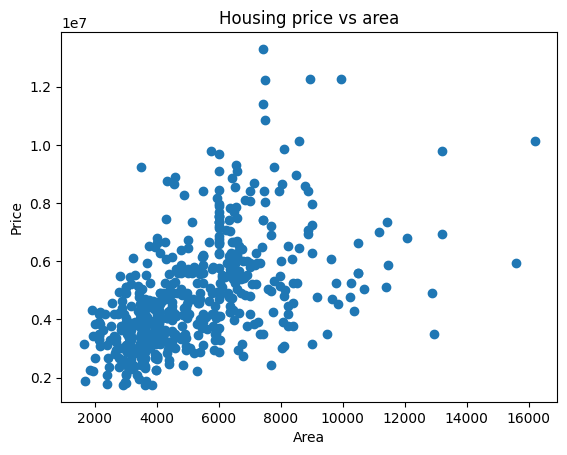

In [11]:
plt.scatter(housing['area'], housing['price'])
plt.title('Housing price vs area')
plt.xlabel('Area')
plt.ylabel('Price')
plt.show()

In [12]:
## Now we define X and Y:
X = housing.drop('price', axis = 1)
Y = housing['price']

## Train-test split:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 23
)

In [13]:
### First method: OLS regression
ols = LinearRegression()
ols.fit(X_train, Y_train)

## Coefficients
coeff1 = pd.Series(ols.coef_, index = X.columns) # index = X.columns shows the features' names
coeff1.sort_values(ascending = False) # Automatically show the results, largest to smallest

hotwaterheating                    953584.927983
bathrooms                          950764.545839
airconditioning                    864068.029555
prefarea                           659975.933739
stories                            467835.220003
mainroad                           459561.508789
parking                            341644.622222
basement                           323026.965273
guestroom                          226486.144630
bedrooms                           135267.750368
area                                  229.101256
furnishingstatus_semi-furnished   -160409.702833
furnishingstatus_unfurnished      -513360.664791
dtype: float64

In [14]:
## Test MSE calculation
y_pred_ols = ols.predict(X_test)

mse_test_ols = mean_squared_error(Y_test, y_pred_ols)
rmse_test_ols = np.sqrt(mse_test_ols)

print("Test MSE (OLS):", mse_test_ols)
print("Test RMSE (OLS):", rmse_test_ols)   # Use RMSE for a more standardized error, proportional to prices

Test MSE (OLS): 1044892004348.17
Test RMSE (OLS): 1022199.5912482894


In [15]:
## A few notes on the OLS regression:
# OLS has high interpretability
# Higher variance
# Sensitive to corellation between regressors
# Assume linear relationships between housing prices and regressors

## Interpretation of the result:
# 1. Bathrooms, hot water heating, air conditioning and prefered area location have the most significant impact on house prices. Exp: If we hold other 
# variables constant, having hot water heating is associated with a surplus of 953584 in price
# 2. Infrastructural features such as stories, mainroad, parking and basement comtrubute moderately to housing price
# 3. Furnishing status coeficients are negative, suggesting that semi-furnished and unfurnished houses are in average 160000 and 513000 lesser in values  
# compared to furnished houses

In [16]:
### Second method: Ridge regression
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [17]:
## Define model pipeline (Steps are chained together)
ridge_pipe = Pipeline(steps = [
    ("scaler", StandardScaler(with_mean = True, with_std = True)),
    ("ridge", Ridge())
]) # Scale X then fit ridge inside each training fold

In [18]:
## Define lambda grid (possible parameter values to test):
lambdas = np.logspace(-3, 5, 60)  # Base is 10 by default, so from 10^-3 to 10^5, take 60 lambdas 
param_grid = {"ridge__alpha": lambdas}   # Inside Pipeline: Step name = "ridge", "ridge" parameter = alpha. So whenever we go to the step "ridge" in
                                         # GridSearchCv, it will try different lambdas
# We use logspace because regularization strength changes multiplicatively

In [19]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 23)   # shuffle dataset before splitting, better representative if data is sorted
grid_ridge = GridSearchCV(   # Try many possible combinations of parameters and pick the best one 
    estimator = ridge_pipe,      # Take this pipeline (model), change alpha(lambda), run fit/predict
    param_grid = param_grid,    # Different lambdas to be tested and where to put the lambdas in
    cv = cv,   # How we split the data (how many folds)
    scoring = "neg_root_mean_squared_error", # RMSE directly, multiply 1 because sklearn maximizes scores
)

grid_ridge.fit(X_train, Y_train)   # Set alpha, for each split: fit training folds, predict validation fold. Average RMSE across folds


print("Best lambda:", grid_ridge.best_params_["ridge__alpha"])   # Lambda that produces the best average RMSE during Cross-Validation
print("Best CV RMSE:", -grid_ridge.best_score_)   

Best lambda: 40.75392965871778
Best CV RMSE: 1132111.9654573204


In [20]:
final_ridge = grid_ridge.best_estimator_    # The best lambda fitted on full training set, the refitted 
                                     # ridge model on scaled training data => final coeffs
y_pred_ridge = final_ridge.predict(X_test)

rmse_test_ridge = np.sqrt(mean_squared_error(Y_test, y_pred_ridge))
print("Test RMSE (Ridge):", rmse_test_ridge)

Test RMSE (Ridge): 1017329.1210440347


In [21]:
## Interpretation of the result:
# The average house price is 4.7 million, using scaler of 40.75, the ridge model achieved an average error of 1.02/4.7 = 21% of the average price
# Compared to OLS, the ridge regression RSME is 1022199-1017329 = 4870 lesser than the OLS RMSE => Slightly improved 
# This showed that regularization marginally outperformed simple OLS by introducing little bias and reducing variance. This suggests there is a slight 
# multicollinearity between regressors in OLS and ridge improved it

In [22]:
### Cubic spline regression:
# Besides the OLS and the ridge regression, we also implement non-linear approximation of the housing prices using cubic spline regression 
# Cubic spline regression offers a more flexible modeling of non-linear relationship while ensuring smoothness at predefined knot
# In the setting, we will apply cubic spline to continuous variables and linear regression (OLS) to binary variables


import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error


In [23]:
## Seperate continuous and binary variables:
cont_X = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

bina_X = [
    'mainroad', 'guestroom', 'basement',
    'hotwaterheating', 'airconditioning', 'prefarea',
    'furnishingstatus_semi-furnished',
    'furnishingstatus_unfurnished'
]

# Since spline model curvatures, it is for continuous variables
# Since binary variables have only 2 values each, curvature is meaningless (still put them into linear regression to preserve predictivity)

In [24]:
## Apply different transformations to different columns:
preprocessor = ColumnTransformer(
    transformers=[     # Each element is a tuple ("name", transformer, columns)
        ("spline",SplineTransformer(degree=3, include_bias=False), cont_X),    # include_bias = False avoid duplicating the intercept columns
        ("binary", "passthrough", bina_X)]   # For binary X just "passthrough" this step (unchanged)
)

# SplineTransformer: Take 1 continuous column (Exp: Area) and replace it with many new columns (basis functions). degree = 3 (cubic), n_knots = k 
# Output: matrix with more columns than original features

In [25]:
## Pipeline (chain of steps that behaves like one model with .fit() and .predict()):
spline_pipe = Pipeline(steps = [            
    ("preprocess", preprocessor),
    ("regression", LinearRegression())
])         # Preprocess => regress

In [26]:
## Using CV to choose number of knots
param_grid = {"preprocess__spline__n_knots": [3, 4, 5, 6, 7, 8]}   # Try these n_knots in the "spline" in "preprocess"

cv = KFold(n_splits = 5, shuffle = True, random_state = 23)

grid_spline = GridSearchCV(
    estimator = spline_pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = "neg_root_mean_squared_error"
)        # Repeat: Set  1 param, run k-fold CV, retrieve score, pick the best score, refit the best model on full training data

grid_spline.fit(X_train, Y_train)    # What happened: Transform training columns into basis functions => do linear regression on the transformed X(
                                     # Train on 4 fold, used trained coefficients to predict validation fold, repeat 5 times, take average)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'preprocess__spline__n_knots': [3, 4, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed

In [27]:
## Achieved the best model:
print("Best number of knots:", grid_spline.best_params_["preprocess__spline__n_knots"])    # n_knot with the lowest CV RMSE

print("Best CV RMSE:", -grid_spline.best_score_)      # Corresponding lowest CV RMSE

Best number of knots: 3
Best CV RMSE: 1183259.9279006026


In [28]:
## Test RMSE:
final_spline = grid_spline.best_estimator_

y_pred_spline = final_spline.predict(X_test) 

rmse_test_spline = np.sqrt(mean_squared_error(Y_test, y_pred_spline))

print("Test RMSE (Spline):", rmse_test_spline)

Test RMSE (Spline): 1074321.2035765518


In [29]:
## Interpretation
# By using cubic spline regression model which assumes non-linear relationship in continuous regressors, we achieved a test RMSE of 1074321, higher 
# than both Ridge and OLS regression test RMSE. So the performance is worse

# The CV procedure result in a small number of optimal knots, indicating a signal of linearity in the true model. The added flexibility has indeed 
# introduce a higher variance in the model, capturing noise

# The rather small number of observations (545) also limits the ability to apply non-linear regression model since overfit is likely to happen in a 
# small sample of observations

In [30]:
# OLS: unbiased but higher variance (test RMSE: 1022199)
# Ridge: Higher bias but reduce variance through regularization (test RMSE: 1017329)
# Cubic spline: Too much flexibility, variance increases (test RMSE: 1074321)

# => This leads to a Bias-variance Tradeoff: Modest regularization improve the final prediction by generalization, while implying too much flexibility 
# through spline to a data set with small number of observations will increase bias, leading to higher test RMSE

In [31]:
### Final conclusion:
# This project compared 3 types of commonly used regression model: original OLS, Ridge regression and Cubic spline regession for housing price 
# prediction. Model parameters such as Ridge lambda(scaler) and number of knots in Spline regression were chosen by 5-fold CV selection. Ridge 
# regression achieved the smallest test RMSE due to moderate regularization while spline, in the other hand, results n the largest test RMSE. 
# Non-linear method did not gain more pridictive power, suggesting that the true relationships between housing price and other elements is mostly 
# linear within the observations presented. The final reults emphasized the importance of comparing multiple regression methods in selecting the final
# model and discovering the true underlying relationships of variables.

In [32]:
### Final remark: All parameters are chosen explicitly through Cross-validation process using predefined training data set. This
# is to avoid data leakage and retain the validity of the prediction of the test data set.